### Uncertainty Prediction House Prices

In [45]:
from sklearn.datasets import load_boston
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import statistics as stat


%matplotlib inline

In [3]:
boston_dataset = load_boston()

In [5]:
boston_dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [7]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [8]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [9]:
boston['MEDV'] = boston_dataset.target

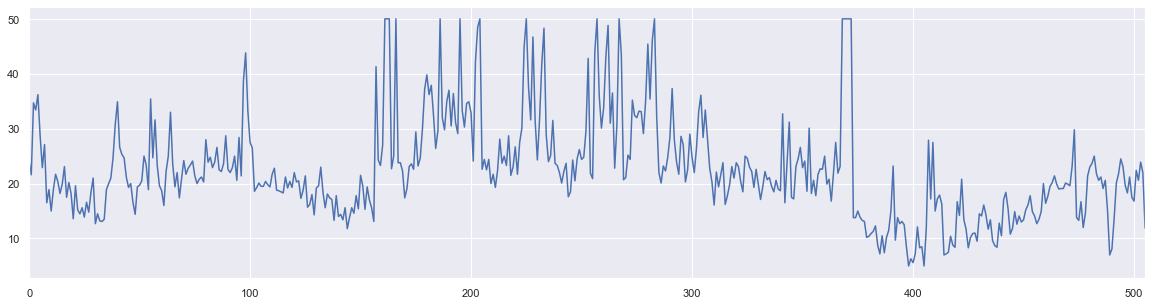

In [250]:
boston['MEDV'].plot(figsize=(20, 5))

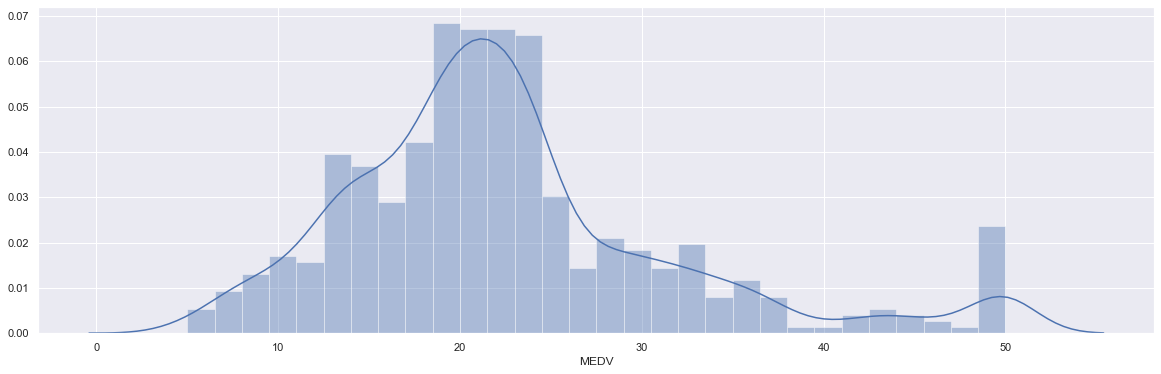

In [255]:
sns.set(rc={'figure.figsize':(20,6)})
sns.distplot(boston['MEDV'], bins=30)
plt.show()

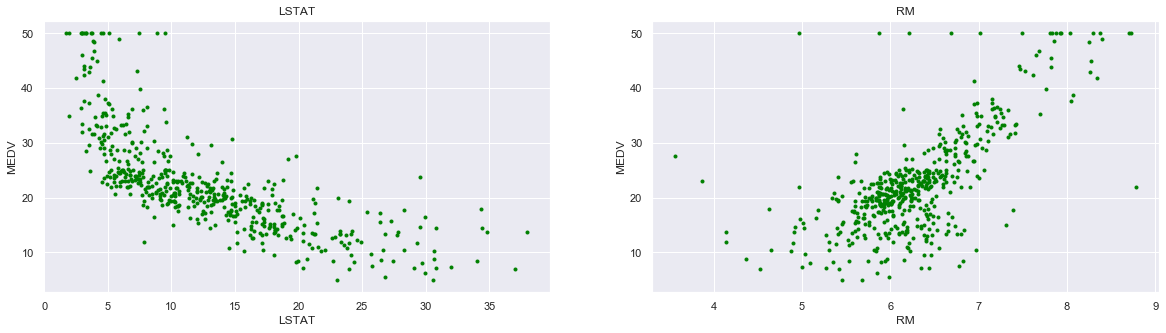

In [13]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.plot(x, y, '.', color= 'green')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

### Prepare data for training

#### Build vectors with the response target variable and sigma

In [194]:
boston['MEDV'].size, boston['LSTAT'].size

(506, 506)

In [195]:
# Add in column of dummy zeros to represent sigma 
#sigma = pd.DataFrame(np.zeros(boston['MEDV'].size))
sigma = np.zeros(boston['MEDV'].size)
Y = pd.DataFrame(np.array([boston['MEDV'], sigma]).T, columns = ['y','sigma'])
X = pd.DataFrame(np.array([boston['LSTAT'], boston['RM']]).T, columns = ['LSTAT','RM'])

In [196]:
Y.tail()

,y,sigma
501,22.4,0.0
502,20.6,0.0
503,23.9,0.0
504,22.0,0.0
505,11.9,0.0


In [197]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split
x, x_val, y, y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [198]:
x, x_val, y, y_val = x.values, x_val.values, y.values, y_val.values

In [199]:
y.size, x.size

(808, 808)

<Figure size 1008x432 with 0 Axes>

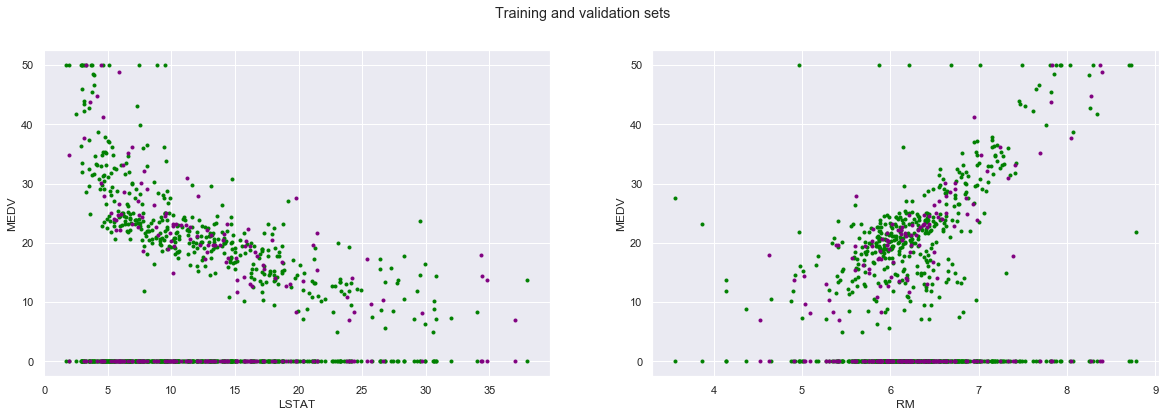

In [264]:
# Plot the data
plt.figure(figsize=(14,6))
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Training and validation sets')
ax1.plot(x[:,0], y, '.', color= 'green')
ax1.plot(x_val[:,0], y_val, '.', color='purple')
ax1.set(xlabel='LSTAT', ylabel='MEDV');
ax2.plot(x[:,1], y, '.', color= 'green')
ax2.plot(x_val[:,1], y_val, '.', color='purple')
ax2.set(xlabel='RM', ylabel='MEDV');

In [201]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.cuda.FloatTensor
x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [202]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([404, 2]), torch.Size([404, 2]))

### Experiment

#### Create a simple network

In [211]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 2
n_outputs = 2
n_hidden = 1000
model_1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           ).cuda()

In [212]:
# Adam optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

#### Create loss function

In [213]:
def loss_variance_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

#### Training loop

In [214]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model_1(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 3.76e+05
epoch:  500 loss: 2.63e+03
epoch: 1000 loss: 2.5e+03
epoch: 1500 loss: 2.44e+03
epoch: 2000 loss: 2.37e+03
epoch: 2500 loss: 2.22e+03
epoch: 3000 loss: 2.07e+03
epoch: 3500 loss: 1.98e+03
epoch: 4000 loss: 1.92e+03
epoch: 4500 loss: 1.92e+03
epoch: 5000 loss: 1.94e+03
epoch: 5500 loss: 1.95e+03
epoch: 6000 loss: 1.9e+03
epoch: 6500 loss: 1.83e+03
epoch: 7000 loss: 1.71e+03
epoch: 7500 loss: 1.58e+03
epoch: 8000 loss: 1.43e+03
epoch: 8500 loss: 1.35e+03
epoch: 9000 loss: 1.3e+03
epoch: 9500 loss: 1.2e+03


#### Get predictions for validation set

In [220]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model_1(x_val_t)

# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

In [231]:
y_pred_1.data.shape, sigma_pred_1.shape, x_val_t[:,0].shape

(torch.Size([102]), torch.Size([102]), torch.Size([102]))

#### Plot results

<Figure size 1008x432 with 0 Axes>

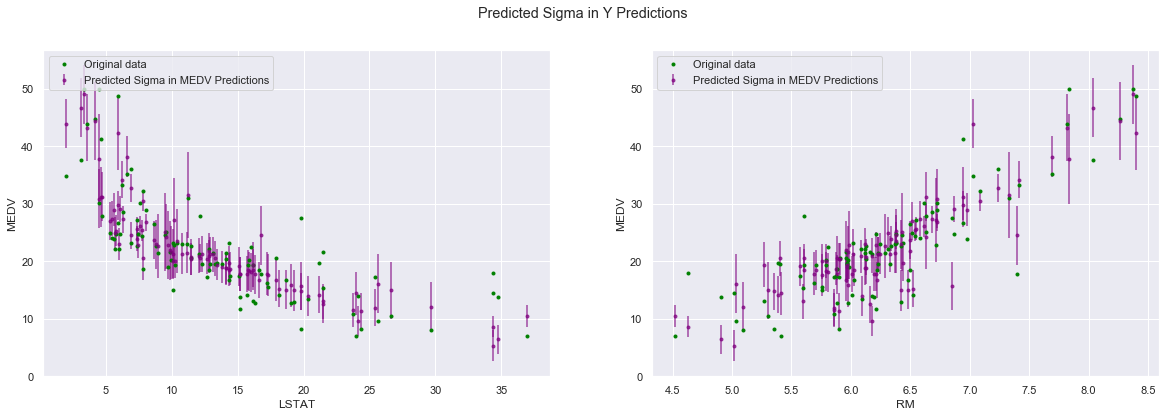

In [322]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Predicted Sigma in Y Predictions')
ax1.plot(x_val[:,0], y_val[:,0], '.', color='green')
#ax1.errorbar(x_val[:,0], y_val[:,0], yerr=sigma_pred_1.sqrt(), alpha=0.7, color='green', fmt='.'); 
ax1.errorbar(x_val[:,0], y_pred_1, yerr=abs(sigma_pred_1).sqrt() ,  alpha=0.7,color='purple', fmt='.'); 
ax1.set_xlabel(r'LSTAT');
ax1.set_ylabel(r'MEDV');
ax1.legend([r'Original data', 'Predicted Sigma in MEDV Predictions'], loc='upper left', );

ax2.plot(x_val[:,1], y_val[:,0], '.', color='green')
#ax2.errorbar(x_val[:,1], y_val[:,0], yerr=sigma_pred_1.sqrt(), alpha=0.7, color='green', fmt='.'); 
ax2.errorbar(x_val[:,1], y_pred_1, yerr=abs(sigma_pred_1).sqrt(), alpha=0.7, color='purple', fmt='.'); 
ax2.set_xlabel(r'RM');
ax2.set_ylabel(r'MEDV');
ax2.legend([r'Original data','Predicted Sigma in MEDV Predictions'], loc='upper left', );

In [236]:
real_sigma = (y_pred_1.numpy()- y_val[:,0])**2

<Figure size 1008x432 with 0 Axes>

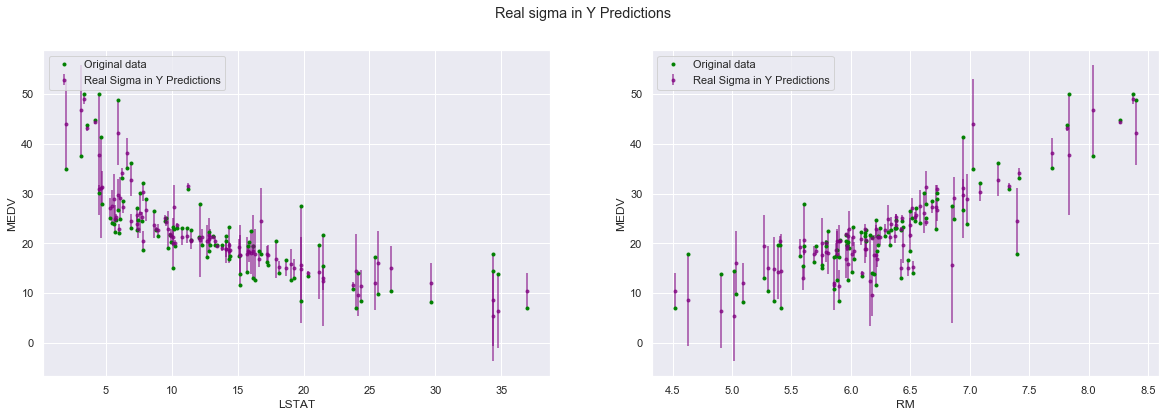

In [300]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Real sigma in Y Predictions')
ax1.plot(x_val[:,0], y_val[:,0], '.', color='green')
#ax1.errorbar(x_val[:,0], y_val[:,0], yerr=np.sqrt(real_sigma), alpha=0.7, color='green', fmt='.'); 
ax1.errorbar(x_val[:,0], y_pred_1, yerr=np.sqrt(real_sigma) ,  alpha=0.7,color='purple', fmt='.'); 
ax1.set_xlabel(r'LSTAT');
ax1.set_ylabel(r'MEDV');
ax1.legend([r'Original data', 'Real Sigma in Y Predictions'], loc='upper left', );

ax2.plot(x_val[:,1], y_val[:,0], '.', color='green')
#ax2.errorbar(x_val[:,1], y_val[:,0], yerr=np.sqrt(real_sigma), alpha=0.7, color='green', fmt='.'); 
ax2.errorbar(x_val[:,1], y_pred_1, yerr=np.sqrt(real_sigma), alpha=0.7, color='purple', fmt='.'); 
ax2.set_xlabel(r'RM');
ax2.set_ylabel(r'MEDV');
ax2.legend([r'Original data', 'Real Sigma in Y Predictions'], loc='upper left', );